Sprint8

# アンサンブル学習 (House Prices )
## データ確認と説明変数、目的変数抽出

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Rawdata = pd.read_csv("/home/hiro/デスクトップ/House Prices/train.csv")

In [2]:
Rawdata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# テスト用と検証用で分割
Data = Rawdata[["GrLivArea", "YearBuilt"]]
Target = pd.DataFrame(Rawdata["SalePrice"])
X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.2, shuffle=False)

In [4]:
X_train.shape

(1168, 2)

## 線形回帰、SVM、決定木でスタッキング
今回は、線形回帰とSVMをstage0で使用し、stage1で決定木を使用する。

### スタッキング学習フェイズ

In [5]:
# """
# sklearnのLRとSVRの出力のshapeが異なる
# """
# model1 = LinearRegression()
# model1.fit(X_train, y_train[:,0])
# y_pred1 = model1.predict(X_train)
# print(y_pred1.shape)
# model2 = SVR()
# print(y.shape)
# model2.fit(X_train, y_train)
# y_pred = model2.predict(X_train)
# print(y_pred.shape)
# # (1460, 1)
# # (1460,)
# # (1460,)

In [6]:
# 学習 Stage0
# 線形回帰
from sklearn.linear_model import LinearRegression
# SVM 回帰分析
from sklearn.svm import SVR
from sklearn.model_selection import KFold

# array変換
X = np.array(X_train)
y = np.array(y_train)

# 検証結果を保存
model1_y = []
model2_y = []

# 各モデルのインスタンスを保存
model1_instance = []
model2_instance = []

# KFoldによる分割
kf = KFold(n_splits=20)

# クロスバリケーション
for train_index, test_index in kf.split(X):
    """"
    学習フェーズ
    """
    # 分割したインデックスからサンプルを取得
    #print("---------------------")
    #print(np.sum(train_index))
    stage0_train_X = X[train_index]
    stage0_y = y[train_index]
    
    # 線形回帰(model1)
    model1 = LinearRegression()
    # SVM 回帰分析
    model2 = SVR()

    # 学習データでフィット
    model1.fit(stage0_train_X, stage0_y)
    model2.fit(stage0_train_X, stage0_y)
    
    # 学習モデルを保存(インスタンス)
    model1_instance.append(model1)
    model2_instance.append(model2)
    
    """"
    検証フェーズ
    """
    # 分割したインデックスからサンプルを取得
    stage0_test_X = X[test_index]
    # テスト結果保存
    model1_y.append(model1.predict(stage0_test_X))
    #print(model1_y.shape())
    # SVRは出力が(n,1)ではなく(n,)となるため、[:, np.newaxis]を入れる
    model2_y.append(model2.predict(stage0_test_X)[:, np.newaxis])
    #print(model2_y.shape())

# Numpyに変換
model1_y = np.vstack(model1_y)
model2_y = np.vstack(model2_y)

# Stage1用の学習データ
model3_X = np.hstack((model1_y, model2_y))

In [7]:
model1_y.shape

(1168, 1)

上記でStage0の処理が完了した。この結果から決定木で回帰を実行する。

In [8]:
# 学習 Stage1
# 決定木回帰
from sklearn.tree import DecisionTreeRegressor

y = np.array(y_train)

# 検証結果を保存
model3_y = []

# 各モデルのインスタンスを保存
model3_instance = []

""""
学習フェーズ
"""
# 決定木(model3)
model3 = DecisionTreeRegressor()

# 学習データでフィット
model3.fit(model3_X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### スタッキング推定フェイズ

In [9]:
# 推定 Stage0
# 二乗平均平方根誤差 (RMSE)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# array変換
X = np.array(X_test)
y = np.array(y_test)

# 検証結果を保存
model1_pred_y = []
model2_pred_y = []

# RMSEの結果を保存
model1_score = []
model2_score = []

# KFoldによる分割
kf = KFold(n_splits=20)

for i in range(len(model1_instance)):
#for model1, model2 in zip(model1_instance, model2_instance):
    
    """"
    推定フェーズ
    """
    # テスト結果保存
    model1_pred_y.append(model1_instance[i].predict(X))
    # SVRは出力が(n,1)ではなく(n,)となるため、[:, np.newaxis]を入れる
    model2_pred_y.append(model2_instance[i].predict(X)[:, np.newaxis])
    #print(model2_y.shape())
    
    """"
    スコア
    """
    score1 = np.sqrt(mean_squared_error(y, model1_pred_y[i]))
    score2 = np.sqrt(mean_squared_error(y, model2_pred_y[i]))
    model1_score.append(score1)
    model2_score.append(score2)

# Numpyに変換
# 予測値
model1_pred_y = np.hstack(model1_pred_y)
model2_pred_y = np.hstack(model2_pred_y)

# スコア
model1_score = np.vstack(model1_score)
model2_score = np.vstack(model2_score)

# 平均を求める
model1_y = np.mean(model1_pred_y, axis=1)[:,np.newaxis]
model2_y = np.mean(model2_pred_y, axis=1)[:,np.newaxis]

# Stage1用の学習データ
model3_X = np.hstack((model1_y, model2_y))

In [10]:
print(model1_score)
print(model2_score)

[[54441.89438572]
 [54632.91272845]
 [54541.84974298]
 [54200.56694381]
 [54570.14078798]
 [54433.3381339 ]
 [54472.84789246]
 [54411.62078955]
 [54903.94801254]
 [54398.39697036]
 [54501.33171674]
 [54115.23633653]
 [54474.12723088]
 [54211.61854058]
 [54507.46870429]
 [54554.47853777]
 [54580.87198142]
 [54522.3993113 ]
 [54599.12059404]
 [54521.10187791]]
[[84004.39446631]
 [84117.38256601]
 [84412.00473533]
 [84140.19295498]
 [84412.00348993]
 [84351.83528706]
 [84117.10737921]
 [84233.04326167]
 [84060.406203  ]
 [84117.24663569]
 [84060.40467109]
 [84060.40306271]
 [84292.00410496]
 [84186.38571856]
 [84060.40554012]
 [84117.24838347]
 [84128.70199507]
 [84186.38881589]
 [83959.86918984]
 [84117.24681774]]


In [11]:
# 推定 Stage1
# 二乗平均平方根誤差 (RMSE)
from sklearn.metrics import mean_squared_error

# array変換
y = np.array(y_test)


""""
推定フェーズ
"""
# テスト結果保存
model3_pred_y = model3.predict(model3_X)
    
""""
スコア
"""
model3_score = np.sqrt(mean_squared_error(y, model3_pred_y))

In [12]:
model3_score

62332.47291021542

### model1を線形回帰、決定木、model2をSVMに変更する

In [13]:
# 学習 Stage0
# 線形回帰
from sklearn.linear_model import LinearRegression
# 決定木
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import KFold

# array変換
X = np.array(X_train)
y = np.array(y_train)

# 検証結果を保存
model1_y = []
model2_y = []

# 各モデルのインスタンスを保存
model1_instance = []
model2_instance = []

# KFoldによる分割
kf = KFold(n_splits=20)

# クロスバリケーション
for train_index, test_index in kf.split(X):
    """"
    学習フェーズ
    """
    # 分割したインデックスからサンプルを取得
    stage0_train_X = X[train_index]
    stage0_y = y[train_index]
    
    # 線形回帰(model1)
    model1 = LinearRegression()
    
    # 決定木 回帰分析
    model2 = DecisionTreeRegressor()
    
    # 学習データでフィット
    model1.fit(stage0_train_X, stage0_y)
    model2.fit(stage0_train_X, stage0_y)
    
    # 学習モデルを保存(インスタンス)
    model1_instance.append(model1)
    model2_instance.append(model2)
    
    """"
    検証フェーズ
    """
    # 分割したインデックスからサンプルを取得
    stage0_test_X = X[test_index]
    # テスト結果保存
    model1_y.append(model1.predict(stage0_test_X))
    #print(model1_y.shape())
    # SVRは出力が(n,1)ではなく(n,)となるため、[:, np.newaxis]を入れる
    model2_y.append(model2.predict(stage0_test_X)[:, np.newaxis])
    #print(model2_y.shape())

# Numpyに変換
model1_y = np.vstack(model1_y)
model2_y = np.vstack(model2_y)

# Stage1用の学習データ
model3_X = np.hstack((model1_y, model2_y))

In [14]:
# 学習 Stage1
# 決定木回帰
from sklearn.tree import DecisionTreeRegressor

y = np.array(y_train)

# 検証結果を保存
model3_y = []

# 各モデルのインスタンスを保存
model3_instance = []

""""
学習フェーズ
"""
# 決定木(model3)
model3 = SVR()

# 学習データでフィット
model3.fit(model3_X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

推定

In [15]:
# 推定 Stage0
# 二乗平均平方根誤差 (RMSE)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# array変換
X = np.array(X_test)
y = np.array(y_test)

# 検証結果を保存
model1_pred_y = []
model2_pred_y = []

# RMSEの結果を保存
model1_score = []
model2_score = []

# KFoldによる分割
kf = KFold(n_splits=20)

for i in range(len(model1_instance)):
#for model1, model2 in zip(model1_instance, model2_instance):
    
    """"
    推定フェーズ
    """
    # テスト結果保存
    model1_pred_y.append(model1_instance[i].predict(X))
    # SVRは出力が(n,1)ではなく(n,)となるため、[:, np.newaxis]を入れる
    model2_pred_y.append(model2_instance[i].predict(X)[:, np.newaxis])
    #print(model2_y.shape())
    
    """"
    スコア
    """
    score1 = np.sqrt(mean_squared_error(y, model1_pred_y[i]))
    score2 = np.sqrt(mean_squared_error(y, model2_pred_y[i]))
    model1_score.append(score1)
    model2_score.append(score2)

# Numpyに変換
# 予測値
model1_pred_y = np.hstack(model1_pred_y)
model2_pred_y = np.hstack(model2_pred_y)

# スコア
model1_score = np.vstack(model1_score)
model2_score = np.vstack(model2_score)

# 平均を求める
model1_y = np.mean(model1_pred_y, axis=1)[:,np.newaxis]
model2_y = np.mean(model2_pred_y, axis=1)[:,np.newaxis]

# Stage1用の学習データ
model3_X = np.hstack((model1_y, model2_y))

In [16]:
# 推定 Stage1
# 二乗平均平方根誤差 (RMSE)
from sklearn.metrics import mean_squared_error

# array変換
y = np.array(y_test)


""""
推定フェーズ
"""
# テスト結果保存
model3_pred_y = model3.predict(model3_X)
    
""""
スコア
"""
model3_score = np.sqrt(mean_squared_error(y, model3_pred_y))

In [17]:
model3_score

84128.83884078414

In [18]:
np.mean(model1_score)

54479.76356096049

In [19]:
np.mean(model2_score)

54070.80332432278

SVRを最後にした結果は一回目よりも非常に悪くなった。kaggleではスタッティングする際に最終stageでは決定木を使用するらしい。それは、最後に精度の悪いモデルを持ってくると全体の結果が悪くなるからだと思われる。

## バギング
線形回帰でのバンキングを検証する。sklearnのtrain_test_splitの「shuffle」を「True」にすることで、毎回違うN個のサンプルを取得できる（ブートストラップサンプル）。今回の繰り返し回数は20とする。

In [20]:
# 線形回帰バキング検証

Data = Rawdata[["GrLivArea", "YearBuilt"]]
Target = pd.DataFrame(Rawdata["SalePrice"])

# 予測値
yhats = []

# スコア
yscores = []

# モデル
models = []

# 比較用1回のみ
X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.2, shuffle=True)
lr1 = LinearRegression()
lr1.fit(X_train, y_train)
y1hat = lr1.predict(X_test)

y1_score = np.sqrt(mean_squared_error(y, y1hat))

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.2, shuffle=True)
    
    """
    学習
    """
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    models.append(lr)
    
    """
    推定
    """
    yhats.append(lr.predict(X_test))
    yscores.append(np.sqrt(mean_squared_error(y, yhats[i])))

# Numpyに変換
# 予測値
yhats = np.hstack(yhats)

# スコア
yscores = np.vstack(yscores)

# 平均を求める
yhats = np.mean(yhats, axis=1)[:,np.newaxis]

In [21]:
print(y1_score)

107076.89322742276


In [22]:
print(np.mean(yscores))

104935.33553119931


In [23]:
yscores

array([[ 95202.98140247],
       [100308.11988103],
       [101864.24451494],
       [104921.66926162],
       [ 97249.38211281],
       [104191.24519145],
       [107103.67662025],
       [107986.41525843],
       [104507.07660498],
       [103862.55948727],
       [108901.28989328],
       [108572.0761717 ],
       [107160.3992926 ],
       [104095.28678163],
       [110124.70088161],
       [109446.6427389 ],
       [101446.16953818],
       [104657.49941082],
       [111237.6335697 ],
       [105867.64201033]])

同じデータ入力してテスト行う。

In [24]:
X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.2, shuffle=True)
yhats = []
y1hat = lr1.predict(X_test)
y1_score = np.sqrt(mean_squared_error(y, y1hat))

for i in range(len(models)):
    models[i].predict(X_test)
    yhats.append(lr.predict(X_test))

# 予測値
yhats = np.hstack(yhats)

# 平均を求める
yhats = np.mean(yhats, axis=1)[:,np.newaxis]

yhats_score = np.sqrt(mean_squared_error(y, yhats))

In [25]:
print(y1_score)

104481.5072725789


In [26]:
print(yhats_score)

103691.64333455429


以上の結果からバギングを行った方が良い結果がでる事がわかった。

# Recruit Restaurant
まずは、データの確認を行う。

In [80]:
# Recruit Restaurant データ読込み
air_reserve = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/air_reserve.csv")
air_store_info = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/air_store_info.csv")
air_visit_data = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/air_visit_data.csv")
date_info = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/date_info.csv")
hpg_reserve = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/hpg_reserve.csv")
hpg_store_info = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/hpg_store_info.csv")
sample_submission = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/sample_submission.csv")
store_id_relation = pd.read_csv("/home/hiro/デスクトップ/Recruit Restaurant/store_id_relation.csv")

In [29]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


今回のsubmitにはidにair_store_idを使用する必要がある。<br>
このファイルには、airシステムで行われた予約が含まれている。reserve_datetimeは予約が作成された時刻を示している。visit_datetimeは訪問が行われる時刻である。<br>

カラムの説明<br>
- air_store_id：airシステムのレストランID<br>
- visit_datetime：予約の時間<br>
- reserve_datetime：予約が行われた時間<br>
- reserve_visitors：その予約の訪問者数<br>

In [30]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


このファイルには、hpgシステムで行われた予約が含まれている。<br>

カラムの説明<br>
- hpg_store_id - hpgシステムのレストランのID
- visit_datetime - 予約の時間
- reserve_datetime - 予約が行われた時間
- reserve_visitors - その予約の訪問者数

In [31]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


このファイルには、選択された航空レストランに関する情報が含まれている。列の名前と内容は自明。<br>

- air_store_id：airシステムのレストランID<br>
- air_genre_name：ジャンル名
- air_area_name：住所
- latitude：緯度
- longitude：経度

In [32]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


このファイルには、選択したhpgレストランに関する情報が含まれている。列の名前と内容は自明。<br>

- hpg_store_id：hpgシステムのレストランのID<br>
- hpg_genre_name：ジャンル名
- hpg_area_name：住所
- latitude：緯度
- longitude：経度

In [33]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


このファイルを使用すると、空とhpgシステムの両方を持つ選択レストランに参加できます。

In [34]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


このファイルには、airレストランの履歴データが含まれています。<br>

- air_store_id
- visit_date：日付
- visitors：当日のレストラン訪問者数

In [304]:
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


このファイルは、あなたが予測しなければならない日数を含め、正しい形式で提出物を表示します。<br>

- id：IDが連結することによって形成されるair_store_idとvisit_date下線で
- visitors：店舗と日付の組み合わせについて予測される訪問者の数

In [36]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


このファイルは、データセット内のカレンダー日付に関する基本情報を提供します。<br>

- calendar_date
- day_of_week
- holiday_flg - 日本の休日の日です。

## 折れ線グラフ（横軸：日にち、縦軸：AirREGIで予約された席数の平均値）
air_reserveから「visit_datetime」を日時だけのデータに変換する。

In [97]:
# 時間を取り除いたものを作成
date = air_reserve["visit_datetime"]
date = date.str.split(" ", expand=True)[0]
graf_air_reserve = air_reserve.copy()
graf_air_reserve["visit_datetime"] = date

In [104]:
graf_air_reserve = graf_air_reserve.drop("reserve_datetime", axis=1)
graf_air_reserve.head()

,air_store_id,visit_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01,1
1,air_db4b38ebe7a7ceff,2016-01-01,3
2,air_db4b38ebe7a7ceff,2016-01-01,6
3,air_877f79706adbfb06,2016-01-01,2
4,air_db80363d35f10926,2016-01-01,5


In [115]:
graf_air_reserve.groupby(("visit_datetime"))

In [107]:
grafdata1 = graf_air_reserve.groupby(("visit_datetime")).mean()
grafdata1

,reserve_visitors
visit_datetime,
2016-01-01,3.400000
2016-01-02,5.120000
2016-01-03,4.076923
2016-01-04,4.518519
2016-01-05,3.166667
2016-01-06,3.312500
2016-01-07,3.878049
2016-01-08,4.603774
2016-01-09,3.960938


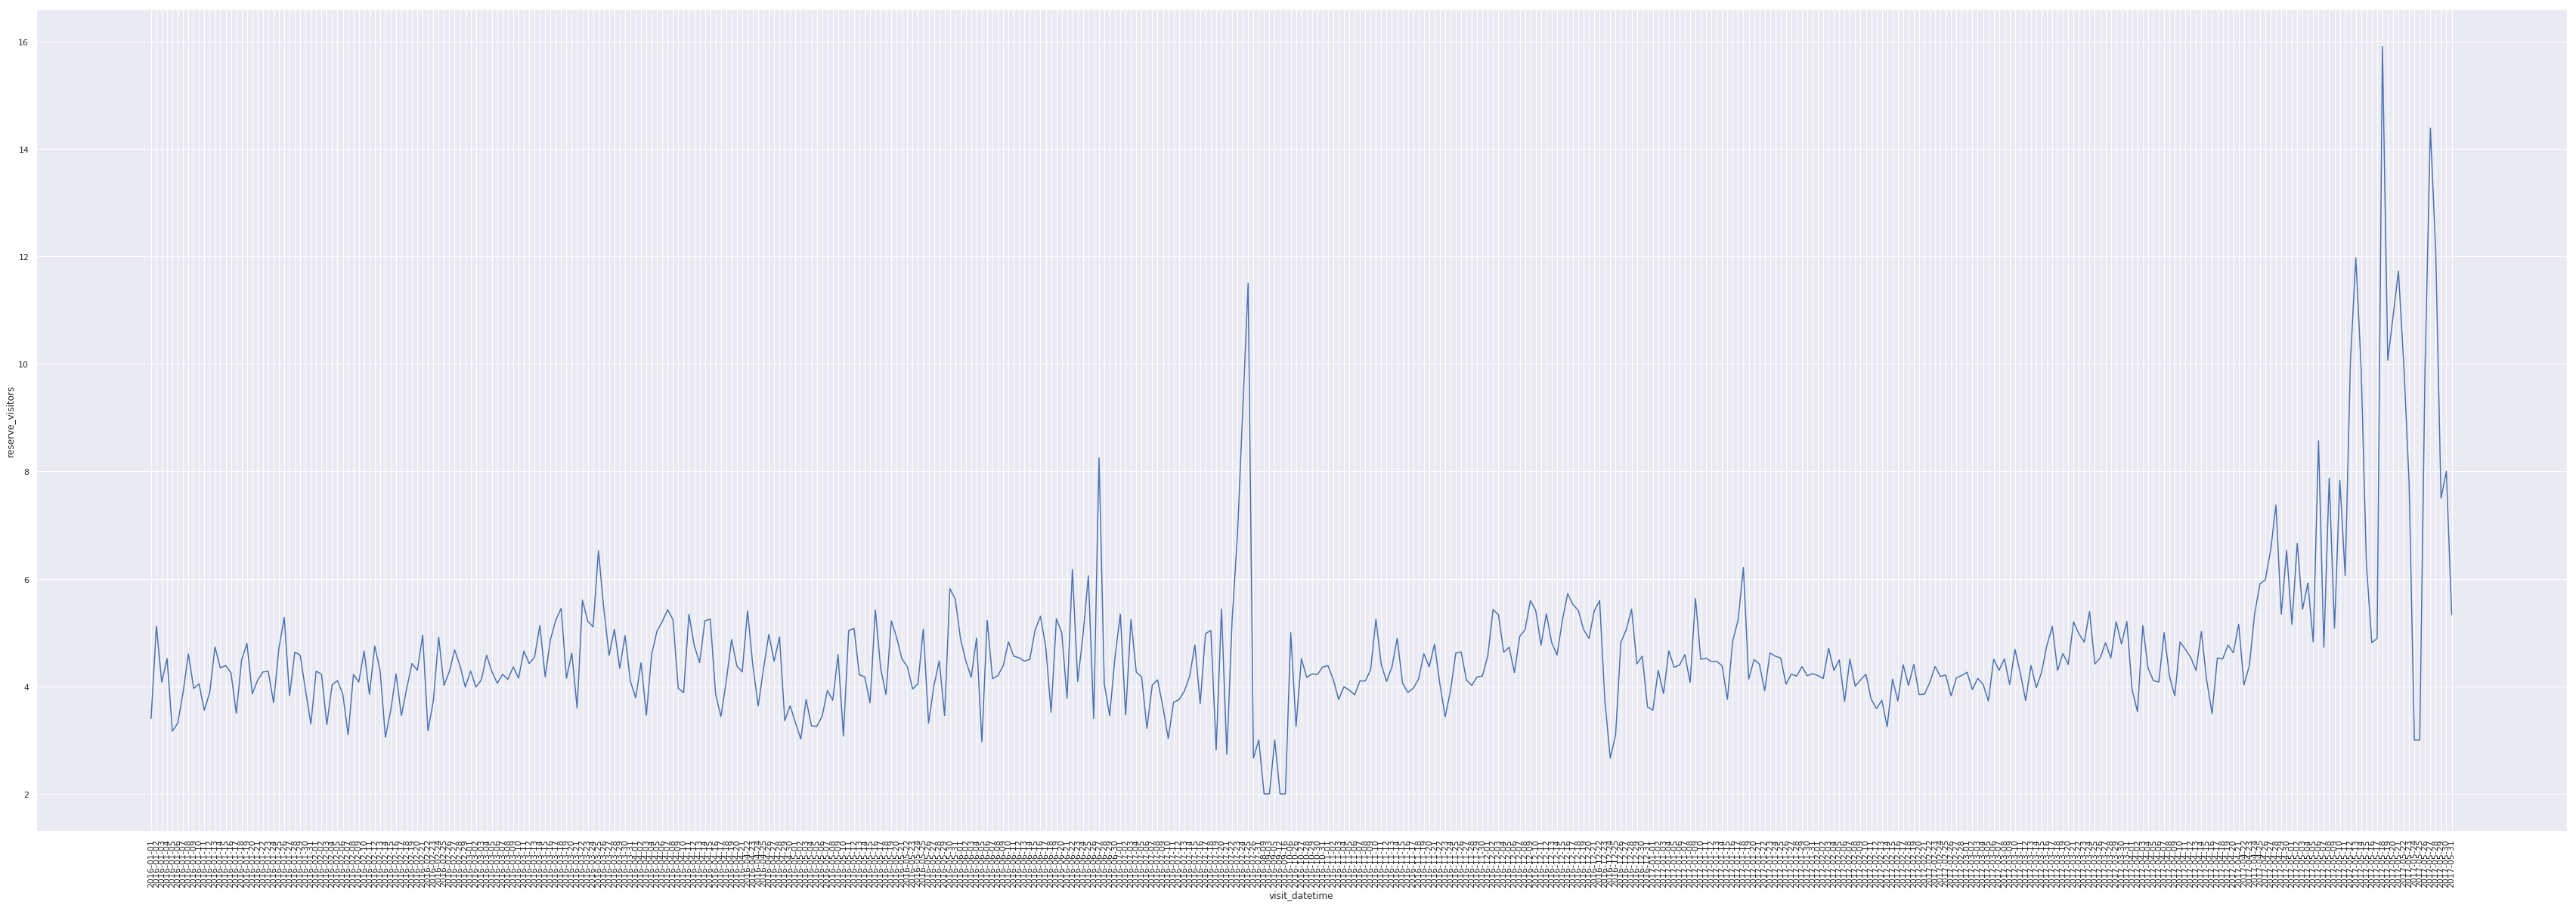

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(60,20))
plt.plot(grafdata1)
plt.xlabel("visit_datetime")
plt.ylabel("reserve_visitors")
plt.xticks(rotation="vertical")
plt.show()

## 折れ線グラフ（横軸：日にち、縦軸：全てのAirREGI登録店の来店数の平均値）

In [153]:
data2 = graf_air_reserve.groupby(("air_store_id", "visit_datetime")).count()
data2

reserve_visitors
air_store_id         visit_datetime                  
air_00a91d42b08b08d9 2016-10-31                     1
                     2016-12-05                     1
                     2016-12-14                     1
                     2016-12-17                     1
                     2016-12-20                     1
                     2017-02-18                     1
                     2017-02-23                     1
                     2017-03-01                     1
                     2017-03-14                     1
                     2017-03-21                     1
                     2017-03-24                     1
                     2017-04-04                     1
air_0164b9927d20bcc3 2016-10-28                     2
                     2016-11-01                     2
                     2016-11-02                     1
                     2016-11-08                     1
                     2016-11-10                     2
                     2016-11-11                     2
                     2016-11-14                     3
                     2016-11-15                     1
                     2016-11-16                     1
                     2016-11-18                     2
                     2016-11-21                     1
                     2016-11-22                     2
                     2016-11-24                     1
                     2016-11-26                     1
                     2016-11-28                     1
                     2016-12-02                     1
                     2016-12-05                     2
                     2016-12-06                     1
...                                               ...
air_fea5dc9594450608 2017-03-08                     1
                     2017-03-10                     1
                     2017-03-11                     3
                     2017-03-16                     1
                     2017-03-17                     3
                     2017-03-18                     2
                     2017-03-21                     2
                     2017-03-22                     1
                     2017-03-23                     1
                     2017-03-24                     1
                     2017-03-25                     3
                     2017-03-29                     1
                     2017-03-30                     2
                     2017-04-01                     1
                     2017-04-05                     1
                     2017-04-07                     1
                     2017-04-08                     1
                     2017-04-11                     1
                     2017-04-12                     1
                     2017-04-14                     1
                     2017-04-15                     2
                     2017-04-18                     1
                     2017-04-19                     1
                     2017-04-20                     1
                     2017-04-21                     3
                     2017-04-22                     1
                     2017-04-25                     1
                     2017-04-28                     1
                     2017-05-20                     1
air_fee8dcf4d619598e 2017-01-09                     2

[29830 rows x 1 columns]

In [154]:
data2 = data2.groupby("visit_datetime").mean()
data2

,reserve_visitors
visit_datetime,
2016-01-01,1.666667
2016-01-02,3.571429
2016-01-03,2.166667
2016-01-04,1.588235
2016-01-05,1.411765
2016-01-06,2.285714
2016-01-07,1.708333
2016-01-08,2.789474
2016-01-09,3.459459


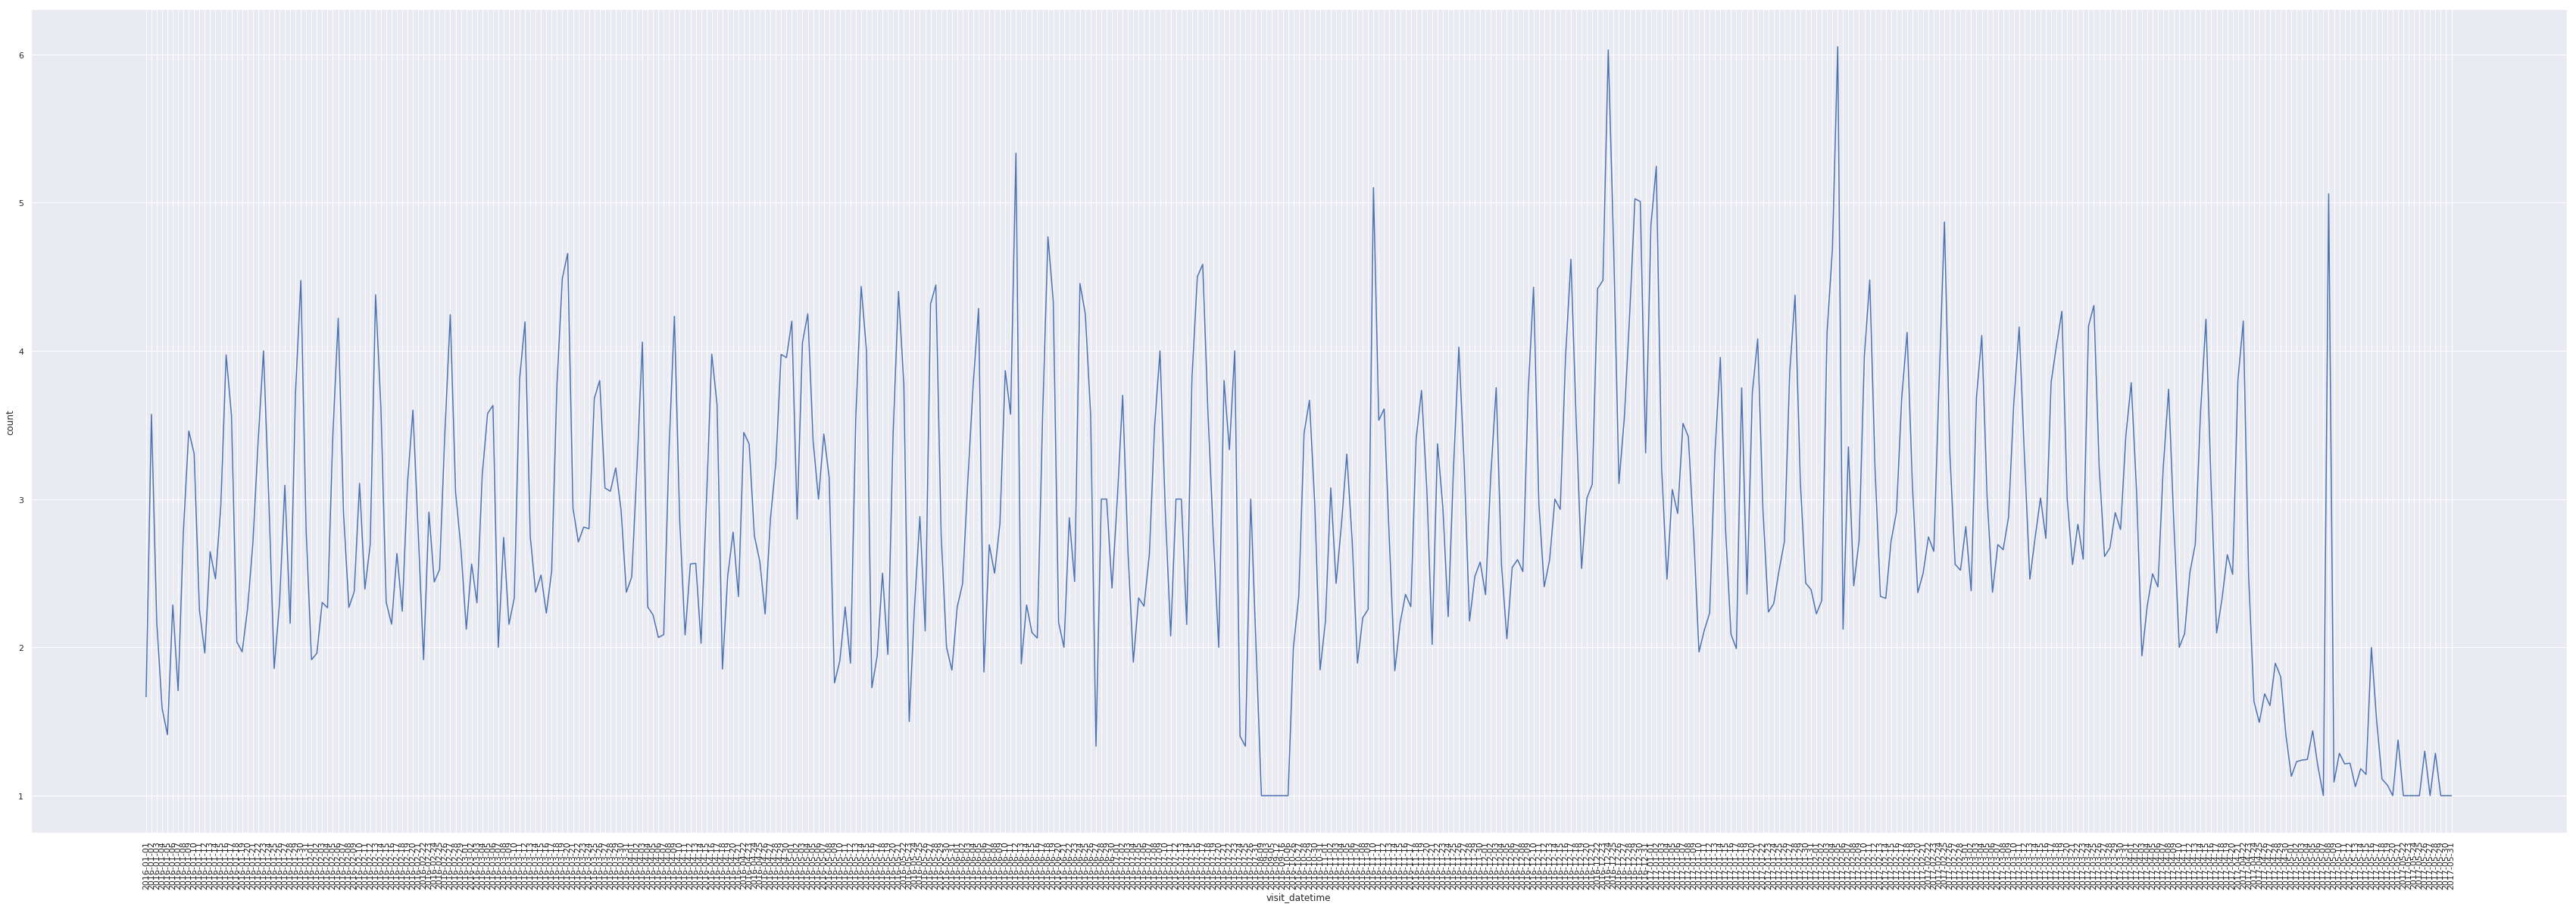

In [141]:
plt.figure(figsize=(60,20))
plt.plot(data2)
plt.xlabel("visit_datetime")
plt.ylabel("count")
plt.xticks(rotation="vertical")
plt.show()

## 棒グラフ（横軸：曜日、縦軸：全てのAirREGI登録店の来店数の平均値
カレンダーデータと上記の日付ごとの来店数を日付をキーにしてマージする。

In [181]:
data2 = data2.reset_index().rename(columns={"visit_datetime":"calendar_date"})
data2

,calendar_date,reserve_visitors
0,2016-01-01,1.666667
1,2016-01-02,3.571429
2,2016-01-03,2.166667
3,2016-01-04,1.588235
4,2016-01-05,1.411765
5,2016-01-06,2.285714
6,2016-01-07,1.708333
7,2016-01-08,2.789474
8,2016-01-09,3.459459
9,2016-01-10,3.307692


In [183]:
data3 = pd.merge(date_info, data2)
data3

,calendar_date,day_of_week,holiday_flg,reserve_visitors
0,2016-01-01,Friday,1,1.666667
1,2016-01-02,Saturday,1,3.571429
2,2016-01-03,Sunday,1,2.166667
3,2016-01-04,Monday,0,1.588235
4,2016-01-05,Tuesday,0,1.411765
5,2016-01-06,Wednesday,0,2.285714
6,2016-01-07,Thursday,0,1.708333
7,2016-01-08,Friday,0,2.789474
8,2016-01-09,Saturday,0,3.459459
9,2016-01-10,Sunday,0,3.307692


In [189]:
graf3data = data3.groupby("day_of_week").mean()
graf3data = graf3data.drop("holiday_flg", axis=1)
graf3data

,reserve_visitors
day_of_week,
Friday,3.294694
Monday,2.181087
Saturday,3.777153
Sunday,3.163316
Thursday,2.479901
Tuesday,2.349860
Wednesday,2.529644


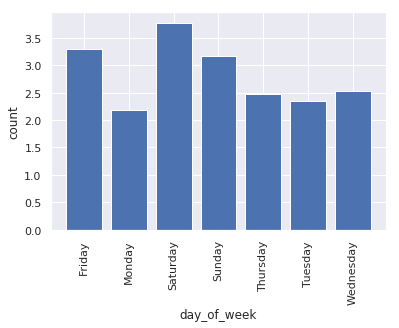

In [222]:
# 棒グラフの場合は一次元でないとダメなので、flatten()を使う
# もしくはravel()
plt.bar(np.array(graf3data.index).ravel(), np.array(graf3data.values).ravel())
plt.xlabel("day_of_week")
plt.ylabel("count")
plt.xticks(rotation="vertical")
plt.show()

## 棒グラフ（横軸：holiday_flgが0か1か、縦軸：全てのAirREGI登録店の来店数の平均値）

In [228]:
graf4data = data3.groupby("holiday_flg").mean()

In [229]:
graf4data

,reserve_visitors
holiday_flg,
0,2.794847
1,3.262475


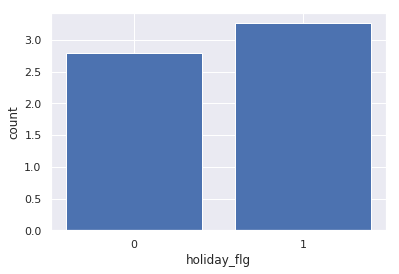

In [241]:
# 棒グラフの場合は一次元でないとダメなので、flatten()を使う
# もしくはravel()
plt.bar(("0", "1"), np.array(graf4data.values).ravel())
plt.xlabel("holiday_flg")
plt.ylabel("count")
plt.show()

## 棒グラフ（横軸：土日祝かどうか、縦軸：全てのAirREGI登録店の来店数の平均値）

In [244]:
data5 = data3.groupby(("holiday_flg", "day_of_week",)).mean()
data5

reserve_visitors
holiday_flg day_of_week                  
0           Friday               3.293156
            Monday               2.063858
            Saturday             3.810712
            Sunday               3.126302
            Thursday             2.442665
            Tuesday              2.307130
            Wednesday            2.515049
1           Friday               3.312222
            Monday               3.294755
            Saturday             3.290539
            Sunday               3.891270
            Thursday             2.896947
            Tuesday              3.631746
            Wednesday            2.811818

In [275]:
# 土日祝日
not_Weekday = data5.xs(1, level="holiday_flg")
not_Weekday

,reserve_visitors
day_of_week,
Friday,3.312222
Monday,3.294755
Saturday,3.290539
Sunday,3.891270
Thursday,2.896947
Tuesday,3.631746
Wednesday,2.811818


In [277]:
# 平日(flag0)
Weekday = data5.xs(0, level="holiday_flg")

In [278]:
# 土日祝日の平均来客数
# 抽出
tempflag0から土日分 = Weekday.loc[["Sunday", "Saturday"]].values

# 土日祝日 + flag0から土日分の平均を算出
not_Weekday_value = np.mean(np.vstack((not_Weekday.values, temp)))

# 土日を削除
Weekday

,reserve_visitors
day_of_week,
Friday,3.293156
Monday,2.063858
Saturday,3.810712
Sunday,3.126302
Thursday,2.442665
Tuesday,2.307130
Wednesday,2.515049


In [279]:
not_Weekday_value

3.3407012832140666

In [280]:
Weekday = Weekday.drop(index=["Sunday", "Saturday"])
Weekday

,reserve_visitors
day_of_week,
Friday,3.293156
Monday,2.063858
Thursday,2.442665
Tuesday,2.307130
Wednesday,2.515049


In [282]:
Weekday_value = np.mean(Weekday.values)
Weekday_value

2.52437172939212

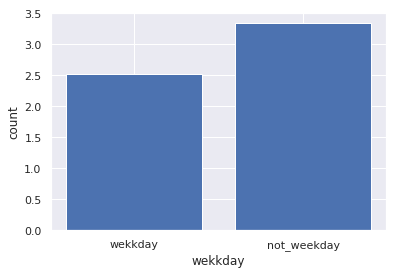

In [283]:
# 棒グラフの場合は一次元でないとダメなので、flatten()を使う
# もしくはravel()
plt.bar(("wekkday", "not_weekday"), (Weekday_value, not_Weekday_value))
plt.xlabel("wekkday")
plt.ylabel("count")
plt.show()

## 棒グラフ（横軸：AirREGI登録店のジャンル、縦軸：登録店数）

In [287]:
data6 = air_store_info.groupby(["air_genre_name"]).count()
data6

,air_store_id,air_area_name,latitude,longitude
air_genre_name,,,,
Asian,2,2,2,2
Bar/Cocktail,79,79,79,79
Cafe/Sweets,181,181,181,181
Creative cuisine,13,13,13,13
Dining bar,108,108,108,108
International cuisine,2,2,2,2
Italian/French,102,102,102,102
Izakaya,197,197,197,197
Japanese food,63,63,63,63


In [290]:
data6["air_store_id"].values

array([  2,  79, 181,  13, 108,   2, 102, 197,  63,   2,  14,  27,  16,
        23])

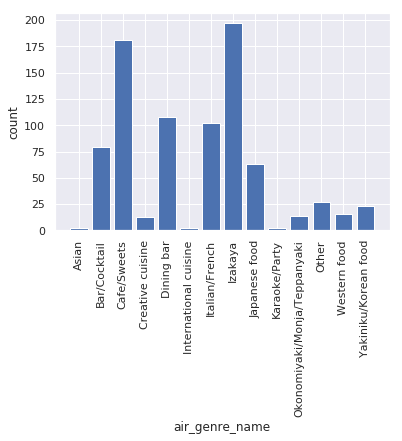

In [293]:
plt.bar(data6.index, data6["air_store_id"].values)
plt.xlabel("air_genre_name")
plt.ylabel("count")
plt.xticks(rotation="vertical")
plt.show()

## 棒グラフ（横軸：AirREGI登録店の都道府県、縦軸：登録店数）

In [297]:
air_store_info["air_area_name"]
# 都道府県のみとりだしたい
air_area_name = air_store_info["air_area_name"]
air_area_name = air_area_name.str.split(" ", expand=True)[0]
data7 = air_store_info.copy()
data7["air_area_name"] = air_area_name
data7

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to,35.658068,139.751599
5,air_99c3eae84130c1cb,Italian/French,Tōkyō-to,35.658068,139.751599
6,air_f183a514cb8ff4fa,Italian/French,Tōkyō-to,35.658068,139.751599
7,air_6b9fa44a9cf504a1,Italian/French,Tōkyō-to,35.658068,139.751599
8,air_0919d54f0c9a24b8,Italian/French,Tōkyō-to,35.658068,139.751599
9,air_2c6c79d597e48096,Italian/French,Tōkyō-to,35.658068,139.751599


In [299]:
graf7 = data7.groupby("air_area_name").count()
graf7

,air_store_id,air_genre_name,latitude,longitude
air_area_name,,,,
Fukuoka-ken,127,127,127,127
Hiroshima-ken,32,32,32,32
Hokkaidō,46,46,46,46
Hyōgo-ken,57,57,57,57
Miyagi-ken,17,17,17,17
Niigata-ken,14,14,14,14
Shizuoka-ken,18,18,18,18
Tōkyō-to,444,444,444,444
Ōsaka-fu,74,74,74,74


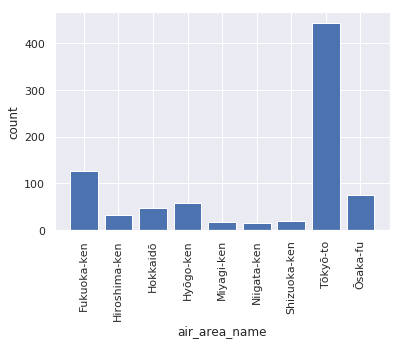

In [300]:
plt.bar(graf7.index, graf7["air_store_id"].values)
plt.xlabel("air_area_name")
plt.ylabel("count")
plt.xticks(rotation="vertical")
plt.show()

## 表（Hot Pepper GourmetとAirREGIの登録店舗数。重複が何店舗かの確認）


In [301]:
store_id_relation

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
5,air_a38f25e3399d1b25,hpg_50378da9ffb9b6cd
6,air_3c938075889fc059,hpg_349b1b92f98b175e
7,air_68301bcb11e2f389,hpg_2c09f3abb2220659
8,air_5f6fa1b897fe80d5,hpg_40aff6385800ebb1
9,air_00a91d42b08b08d9,hpg_fbe603376b5980fc


In [305]:
len(store_id_relation)

150

上記から重複店舗数は150店舗である。

## First Submit
今回は線形回帰で学習する。

In [314]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [310]:
air_visit_data.groupby(["air_store_id", "visit_date"]).mean()

visitors
air_store_id         visit_date          
air_00a91d42b08b08d9 2016-07-01        35
                     2016-07-02         9
                     2016-07-04        20
                     2016-07-05        25
                     2016-07-06        29
                     2016-07-07        34
                     2016-07-08        42
                     2016-07-09        11
                     2016-07-11        25
                     2016-07-12        24
                     2016-07-13        36
                     2016-07-14        28
                     2016-07-15        28
                     2016-07-16         5
                     2016-07-19        25
                     2016-07-20        19
                     2016-07-21        47
                     2016-07-22        53
                     2016-07-23        16
                     2016-07-25        16
                     2016-07-26        16
                     2016-07-27        24
                     2016-07-28        34
                     2016-07-29        31
                     2016-07-30        20
                     2016-08-01        16
                     2016-08-02        24
                     2016-08-03        30
                     2016-08-04        30
                     2016-08-05        42
...                                   ...
air_fff68b929994bfbd 2017-03-24         8
                     2017-03-25         7
                     2017-03-26         3
                     2017-03-27         4
                     2017-03-28         9
                     2017-03-29         2
                     2017-03-30         5
                     2017-03-31         5
                     2017-04-01         9
                     2017-04-02         2
                     2017-04-03         2
                     2017-04-04         4
                     2017-04-05         6
                     2017-04-06         6
                     2017-04-07         9
                     2017-04-08         4
                     2017-04-09         5
                     2017-04-10         6
                     2017-04-11         1
                     2017-04-12         6
                     2017-04-13         1
                     2017-04-14         5
                     2017-04-15         7
                     2017-04-16         7
                     2017-04-17         3
                     2017-04-18         6
                     2017-04-19         2
                     2017-04-20         2
                     2017-04-21         4
                     2017-04-22         5

[252108 rows x 1 columns]

In [337]:
store1 = air_visit_data[air_visit_data.air_store_id == "air_ba937bf13d40fb24"]
store1

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
5,air_ba937bf13d40fb24,2016-01-19,9
6,air_ba937bf13d40fb24,2016-01-20,31
7,air_ba937bf13d40fb24,2016-01-21,21
8,air_ba937bf13d40fb24,2016-01-22,18
9,air_ba937bf13d40fb24,2016-01-23,26


In [338]:
store1.set_index('visit_date', inplace=True)
store1

,air_store_id,visitors
visit_date,,
2016-01-13,air_ba937bf13d40fb24,25
2016-01-14,air_ba937bf13d40fb24,32
2016-01-15,air_ba937bf13d40fb24,29
2016-01-16,air_ba937bf13d40fb24,22
2016-01-18,air_ba937bf13d40fb24,6
2016-01-19,air_ba937bf13d40fb24,9
2016-01-20,air_ba937bf13d40fb24,31
2016-01-21,air_ba937bf13d40fb24,21
2016-01-22,air_ba937bf13d40fb24,18


In [381]:
store1_data = store1['2016-04-23':'2016-05-31']
store1_data.shape

(29, 2)

In [370]:
# 今回は一店舗舗のみ学習
from sklearn.linear_model import LinearRegression

# 日付を連続値に変換 
X = np.array(range(len(store1_data.index)))[:,np.newaxis]
y = store1_data.visitors.values[:,np.newaxis]
store1_model = LinearRegression()
store1_model.fit(X, y)
yhat = store1_model.predict(X)

In [379]:
yhat.shape

(29, 1)

In [378]:
store1_data.index.values

array(['2016-04-23T00:00:00.000000000', '2016-04-25T00:00:00.000000000',
       '2016-04-26T00:00:00.000000000', '2016-04-27T00:00:00.000000000',
       '2016-04-28T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-02T00:00:00.000000000', '2016-05-06T00:00:00.000000000',
       '2016-05-07T00:00:00.000000000', '2016-05-09T00:00:00.000000000',
       '2016-05-10T00:00:00.000000000', '2016-05-11T00:00:00.000000000',
       '2016-05-12T00:00:00.000000000', '2016-05-13T00:00:00.000000000',
       '2016-05-14T00:00:00.000000000', '2016-05-16T00:00:00.000000000',
       '2016-05-17T00:00:00.000000000', '2016-05-18T00:00:00.000000000',
       '2016-05-19T00:00:00.000000000', '2016-05-20T00:00:00.000000000',
       '2016-05-21T00:00:00.000000000', '2016-05-23T00:00:00.000000000',
       '2016-05-24T00:00:00.000000000', '2016-05-25T00:00:00.000000000',
       '2016-05-26T00:00:00.000000000', '2016-05-27T00:00:00.000000000',
       '2016-05-28T00:00:00.000000000', '2016-05-30

In [380]:
sample_submission.shape

(32019, 2)

In [383]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [386]:
timeindex = date_info.set_index("calendar_date")

In [388]:
timeindex = timeindex['2016-04-23':'2016-05-31']

In [392]:
timeindex = timeindex.reset_index()
timeindex = timeindex["calendar_date"]

In [393]:
timeindex

0     2016-04-23
1     2016-04-24
2     2016-04-25
3     2016-04-26
4     2016-04-27
5     2016-04-28
6     2016-04-29
7     2016-04-30
8     2016-05-01
9     2016-05-02
10    2016-05-03
11    2016-05-04
12    2016-05-05
13    2016-05-06
14    2016-05-07
15    2016-05-08
16    2016-05-09
17    2016-05-10
18    2016-05-11
19    2016-05-12
20    2016-05-13
21    2016-05-14
22    2016-05-15
23    2016-05-16
24    2016-05-17
25    2016-05-18
26    2016-05-19
27    2016-05-20
28    2016-05-21
29    2016-05-22
30    2016-05-23
31    2016-05-24
32    2016-05-25
33    2016-05-26
34    2016-05-27
35    2016-05-28
36    2016-05-29
37    2016-05-30
38    2016-05-31
Name: calendar_date, dtype: object

今回は線形回帰で一店舗のみ取り出し学習を行った。しかし、線形回帰では時系列を考慮しないため、今回の対象である未来の予測はできない。それは、時系列を考慮しないモデルに関しては、過去の学習したデータの範囲で予測する。そのため、未来がどうなるかは予測できない。今回の様な時系列を考慮する必要があるものに関しては「RNN」等の時系列を考慮したモデルを使用する必要がある。